In [23]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50


def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)

    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser


In [30]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50

def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)

    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    n1 = len(data_normalised) - history_points
    
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points] for i in range(n1)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points] for i in range(n1)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(n1)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)


    ti = np.array([0]*len(next_day_open_values_normalised))

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0]
    return ohlcv_histories_normalised, ti, next_day_open_values_normalised, next_day_open_values, y_normaliser


In [31]:

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('MSFT_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')



(4483, 50, 5)
(499, 50, 5)


In [37]:
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=10, shuffle=True, validation_split=0.1)


Train on 4034 samples, validate on 449 samples
Epoch 1/10
4034/4034 [==============================] - 2s 467us/step - loss: 1.5153e-04 - val_loss: 5.1384e-05
Epoch 2/10
4034/4034 [==============================] - 2s 451us/step - loss: 1.3274e-04 - val_loss: 5.0402e-05
Epoch 3/10
4034/4034 [==============================] - 2s 452us/step - loss: 1.2398e-04 - val_loss: 1.3246e-04
Epoch 4/10
4034/4034 [==============================] - 2s 448us/step - loss: 1.1957e-04 - val_loss: 1.8389e-04
Epoch 5/10
4034/4034 [==============================] - 2s 446us/step - loss: 1.1143e-04 - val_loss: 1.8874e-04
Epoch 6/10
4034/4034 [==============================] - 2s 442us/step - loss: 1.0422e-04 - val_loss: 1.5312e-04
Epoch 7/10
4034/4034 [==============================] - 2s 424us/step - loss: 9.8164e-05 - val_loss: 3.8685e-05
Epoch 8/10
4034/4034 [==============================] - 2s 428us/step - loss: 9.9357e-05 - val_loss: 7.5797e-05
Epoch 9/10
4034/4034 [==============================] - 2

In [35]:
i=5
y_train[i], ohlcv_train[i]

(array([0.30589912]),
 array([[0.46121402, 0.46767192, 0.44912587, 0.44782483, 0.1053991 ],
        [0.44804788, 0.46018963, 0.44364802, 0.46332469, 0.07056408],
        [0.45659732, 0.48195111, 0.46695804, 0.4889081 , 0.06535972],
        [0.48082075, 0.49623029, 0.49318182, 0.49467012, 0.06312989],
        [0.46976347, 0.48337903, 0.48152681, 0.47738404, 0.04283158],
        [0.47546309, 0.47766735, 0.46765734, 0.4607894 , 0.05279174],
        [0.4523226 , 0.46264565, 0.45932401, 0.4622299 , 0.03546335],
        [0.46018809, 0.46304546, 0.45675991, 0.4622299 , 0.0560484 ],
        [0.45625534, 0.47909527, 0.46404429, 0.48527802, 0.05934709],
        [0.47620405, 0.48052319, 0.4756993 , 0.47375396, 0.03081965],
        [0.46480479, 0.49977153, 0.4756993 , 0.50475367, 0.05976336],
        [0.49934454, 0.51405072, 0.50262238, 0.50763469, 0.07029563],
        [0.52214306, 0.55546036, 0.53467366, 0.55730337, 0.11664565],
        [0.55525791, 0.56762623, 0.55180653, 0.55626621, 0.08586377]

3.4987621426265533e+44


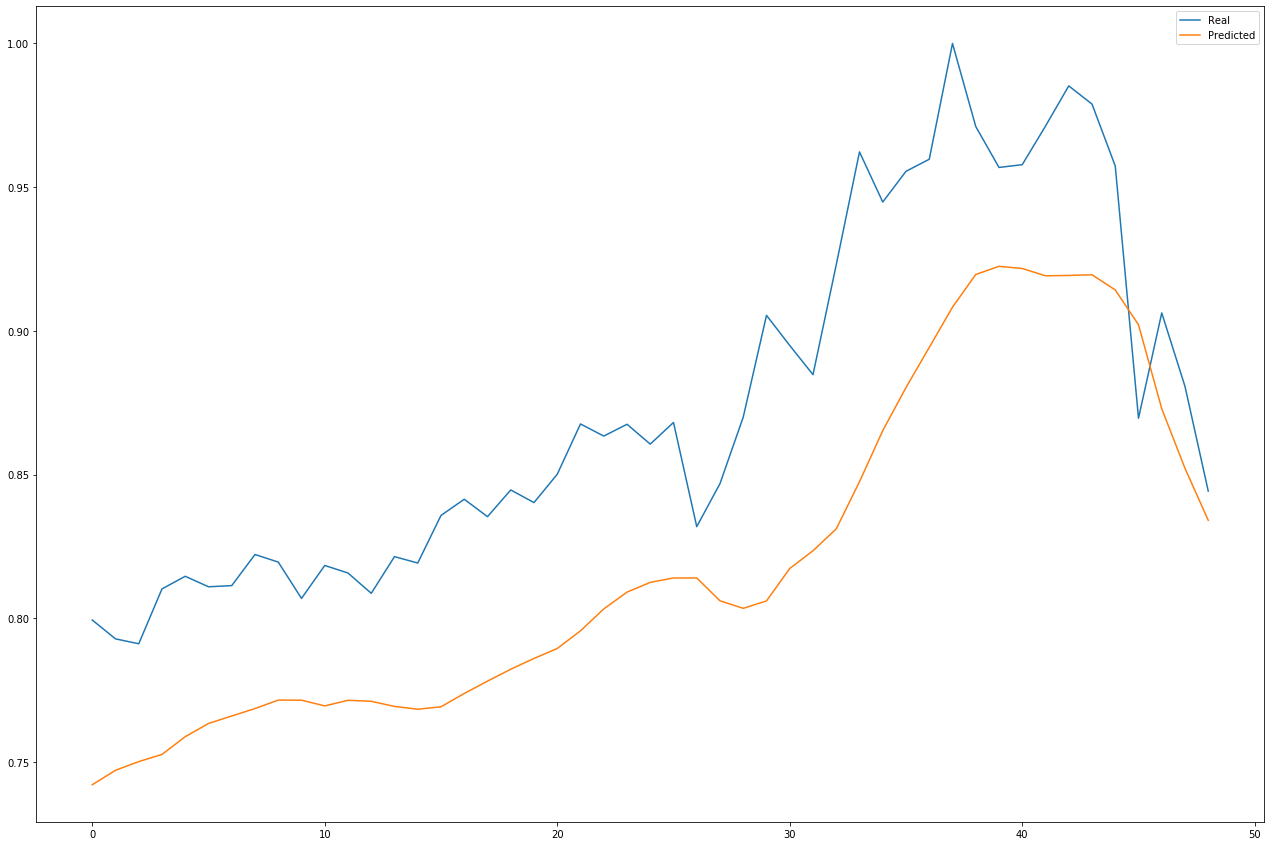

In [49]:
# evaluation

y_test_predicted1= model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = -50
end = -1

#real = plt.plot(unscaled_y_test[start:end], label='real')
#pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(y_test[start:end], label='real')
pred = plt.plot(y_test_predicted1[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime

In [40]:
model.save(f'simple1.h5')


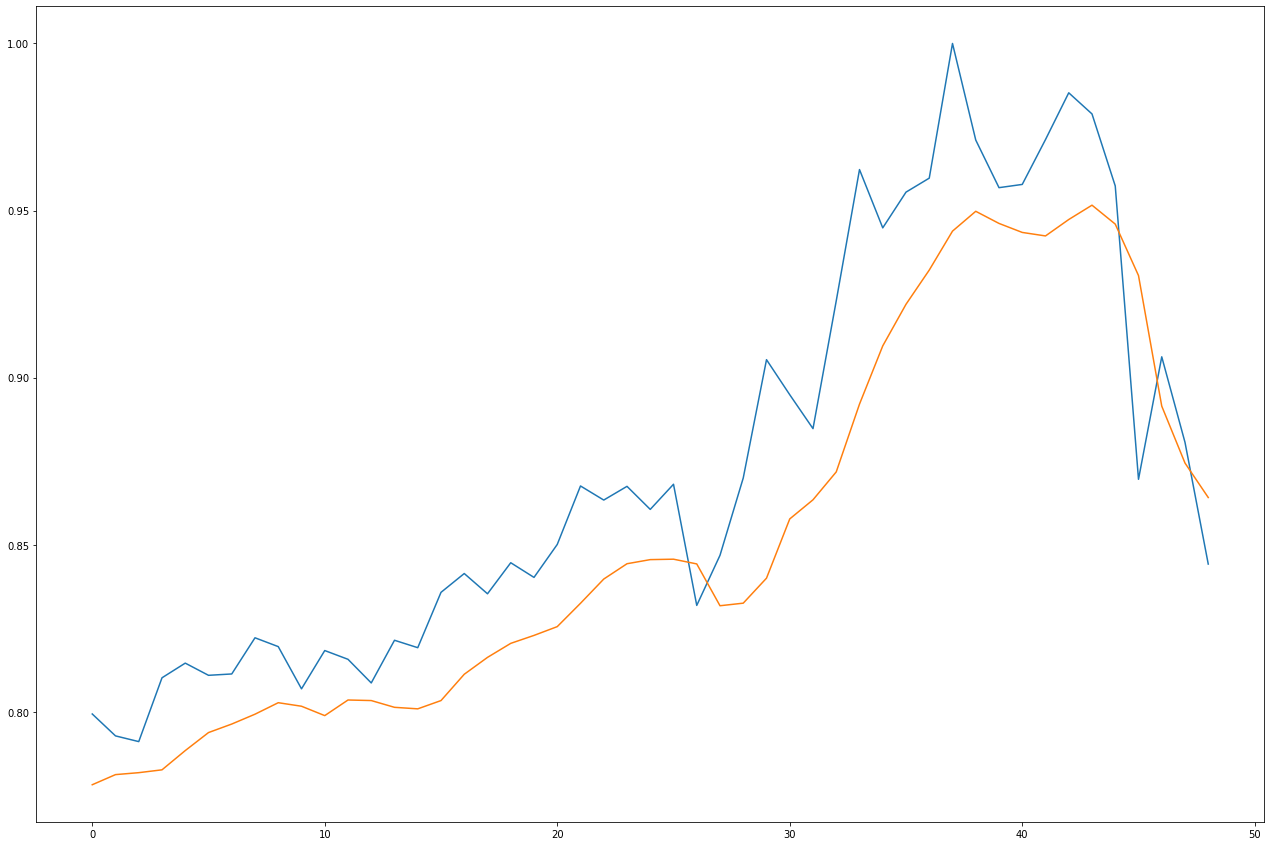

In [48]:
from keras.models import load_model
m1 = load_model(f'simple-sada.h5')

plt.gcf().set_size_inches(22, 15, forward=True)
y_test_predicted1=m1.predict(ohlcv_test)

start = -50
end = -1

#real = plt.plot(unscaled_y_test[start:end], label='real')
#pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(y_test[start:end], label='real')
pred = plt.plot(y_test_predicted1[start:end], label='predicted')
